# Comparing methods for finding marker genes

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/tmp/ipykernel_8423/1565241514.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [14]:
%matplotlib inline

In [15]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [16]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [17]:
import warnings
# warnings.filterwarnings('ignore')

In [18]:
from sklearn.decomposition import PCA

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.8.egg')
import memento

In [21]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'
data_path = '/data_volume/memento/pbmc/'

### Perform some basic filtering

In [22]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells', 'Megakaryocytes', 'Dendritic cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B', 'Mega', 'DC']))

In [23]:
def simplify_name(name):
    return name.split('.')[0]

In [25]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata.obs['ct'] = adata.obs.cell.apply(lambda x: label_converter[x])
adata.obs['ct_shuffled'] = adata.obs['ct'].sample(frac=1.0)

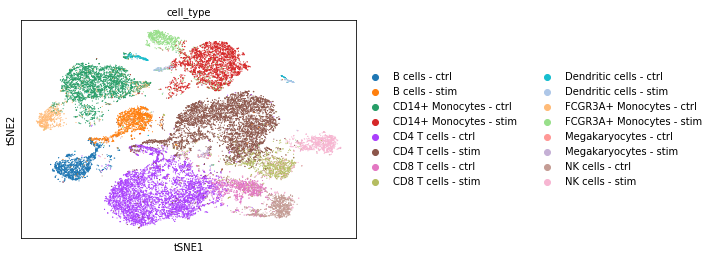

In [26]:
sc.pl.tsne(adata, color='cell_type')

In [27]:
adata = adata[adata.obs['ct'].isin(['Th', 'cM', 'ncM', 'NK', 'Tc', 'B'])].copy()

In [65]:
def get_mean_se(adata, ct_col, marker_for='Th'):
    
    adata.obs['q'] = 0.07
    adata_copy = adata.copy().copy()
    adata_copy.obs['ct_indicator'] = (adata.obs[ct_col] == marker_for).astype(int)
    memento.setup_memento(adata_copy, q_column='q', trim_percent=0.1)
    
    memento.create_groups(adata_copy, label_columns=[ct_col])
    memento.compute_1d_moments(adata_copy, min_perc_group=.5)
    moments = memento.get_1d_moments(adata_copy)

    meta_df = memento.get_groups(adata_copy).astype('category')
#     meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=True)

    treatment = (meta_df[[ct_col]]==marker_for).astype(float)
    covariate = pd.get_dummies(meta_df[[donor_col]], prefix='', prefix_sep='', drop_first=True)
    covariate = pd.concat([covariate, covariate*treatment.values], axis=1)
#     covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)))
    print(treatment)

    result = memento.ht_1d_moments(
        adata_copy, 
        treatment=treatment,
        covariate=covariate,
        num_boot=5000, 
        verbose=1,
        num_cpus=14,
        resample_rep=True,
        approx=False)
    return pd.concat([treatment, covariate], axis=1), adata_copy, result

In [58]:
def run_python_methods(adata, ct_col, marker_for='Th'):
    
    adata.obs['q'] = 0.07
    adata_copy = adata.copy().copy()
    adata_copy.obs['ct_indicator'] = (adata.obs[ct_col] == marker_for).astype(int)
    memento.setup_memento(adata_copy, q_column='q', trim_percent=0.1)
    
    memento.create_groups(adata_copy, label_columns=[ct_col])
    memento.compute_1d_moments(adata_copy, min_perc_group=.5, filter_mean_thresh=0.01)
    moments = memento.get_1d_moments(adata_copy)

    meta_df = memento.get_groups(adata_copy).astype('category')
#     meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=True)

    treatment = (meta_df[[ct_col]]==marker_for).astype(float)
#     covariate = pd.get_dummies(meta_df[[donor_col]], prefix='', prefix_sep='', drop_first=True)
#     covariate = pd.concat([covariate, covariate*treatment.values], axis=1)
    covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)))
    print(treatment)

    memento.ht_1d_moments(
        adata_copy, 
        treatment=treatment,
        covariate=covariate,
        num_boot=5000, 
        verbose=1,
        num_cpus=14,
        resample_rep=True,
        approx=False)
   
    result = memento.get_1d_ht_result(adata_copy)
    
    norm_adata = adata_copy.copy()
    sc.pp.normalize_total(norm_adata)
    sc.pp.log1p(norm_adata)
    genes = list(result.gene.tolist())
    norm_data_overlap = norm_adata[:, genes].copy()
                 
    A_data, B_data = norm_data_overlap[norm_data_overlap.obs[ct_col] == marker_for].X.todense(), norm_data_overlap[norm_data_overlap.obs[ct_col] != marker_for].X.todense()
    _, result['ttest_pval'] = stats.ttest_ind(A_data, B_data, equal_var=False)
#     result['mwu_pval'] = np.array([stats.mannwhitneyu(A_data[:, i], B_data[:,i])[1] for i in range(A_data.shape[1])])
    
    return result, moments, (A_data, B_data)
    

### with PyMARE

In [66]:
design, filtered_adata, means = get_mean_se(adata, 'ct', marker_for='Th')

NameError: name 'donor_col' is not defined

In [60]:
from pymare import estimators, core
results = []

for m,v in means:
    
    df = treatment
    df['m'] = m
    df['v'] = v
    dset = core.Dataset(data=df, y='m', v='v', X=['ct'])
    
    res = estimators.DerSimonianLaird().fit_dataset(dset).summary().to_df().set_index('name').loc['ct', ['estimate', 'p-value']]
    
    results.append(res)
    
memento_results = pd.DataFrame(np.vstack([results]),columns=['coef', 'de_pval'])

memento_results['gene'] = filtered_adata.var.index
# memento_results.to_csv(data_path + 'means/simple/memento_0.csv', index=False)

In [63]:
memento_results['de_fdr'] = memento.util._fdrcorrect(memento_results['de_pval'])

In [64]:
memento_results.query('gene == "IL7R"')

,coef,de_pval,gene,de_fdr
482,2.276434,0.012471,IL7R,0.244625


In [61]:
memento_results.query('coef > 0').sort_values('de_pval').head(30)

,coef,de_pval,gene
1135,0.328376,4.440892e-16,POLR1D
738,0.565240,4.520828e-13,MSL3
443,0.332203,1.098466e-06,G3BP2
1384,0.244527,1.136751e-06,CWC25
1310,0.205263,4.756739e-06,DNAJA2
1500,0.253462,5.254330e-06,DPM1
813,1.217080,8.036938e-05,PABPC1
240,0.348792,8.926848e-05,UGP2
169,0.633395,2.260543e-04,CACYBP
1126,0.108636,2.352527e-04,TMED2


<AxesSubplot:>

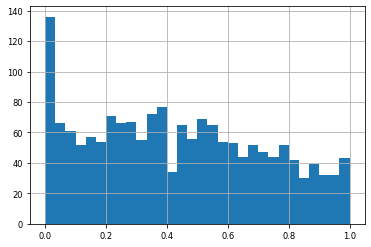

In [54]:
#DS
memento_results.de_pval.hist(bins=30)

<AxesSubplot:>

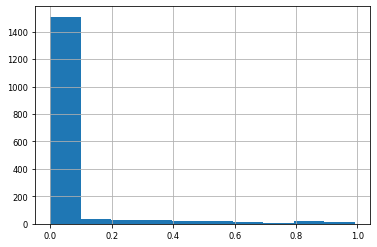

In [51]:
#WLS
memento_results.de_pval.hist()

### With shuffling

In [45]:
adata.obs['barcode'] = adata.obs.index.tolist()

# sample_barcodes = adata.obs.groupby('ct')['barcode'].apply(lambda x: x.sample(min(len(x), 1000))).tolist()
sample_barcodes = pd.Series(adata.obs.index).sample(5000)
adata.obs['ct_fake'] = adata.obs['ct'].tolist()
adata.obs.loc[sample_barcodes, 'ct_fake'] = 'Tx'

# adata.obs['ct_fake'] = adata.obs['ct'].sample(frac=1).tolist()


In [48]:
sresult, smoments, snorm_data = run_python_methods(adata, 'ct_fake', 'ind', marker_for='Tx')

      ct_indicator
sg^0  0.0         
sg^1  1.0         
im here


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    3.4s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    5.1s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:    7.5s
[Parallel(n_jobs=14)]: Done 984 tasks      | elapsed:   13.6s
[Parallel(n_jobs=14)]: Done 1884 tasks      | elapsed:   23.7s
[Parallel(n_jobs=14)]: Done 2121 out of 2148 | elapsed:   26.2s remaining:    0.3s
[Parallel(n_jobs=14)]: Done 2148 out of 2148 | elapsed:   27.3s finished


In [49]:
sresult

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ttest_pval
0,HES4,ct_indicator,-0.007056,0.063881,0.913817,0.031766,0.110174,0.780044,0.979700
1,ISG15,ct_indicator,0.038491,0.035628,0.284943,-0.050941,0.033783,0.131574,0.726663
2,SDF4,ct_indicator,0.068846,0.064965,0.293941,0.945723,0.520141,0.085583,0.686284
3,UBE2J2,ct_indicator,0.117156,0.058245,0.041592,0.355716,0.328693,0.285943,0.094606
4,AURKAIP1,ct_indicator,-0.015980,0.033433,0.633873,0.456264,0.324195,0.171166,0.220298
...,...,...,...,...,...,...,...,...,...
2143,PDXK,ct_indicator,0.088731,0.067072,0.186363,0.338707,0.505464,0.570286,0.271593
2144,CSTB,ct_indicator,0.058103,0.037714,0.125775,0.027405,0.053476,0.607079,0.112056
2145,SUMO3,ct_indicator,-0.043492,0.052428,0.407119,0.260793,0.398771,0.558088,0.203622
2146,PTTG1IP,ct_indicator,-0.025078,0.061191,0.679664,-0.373906,0.356140,0.292541,0.866407


### Without shuffling

In [ ]:
result, moments, norm_data = run_python_methods(adata, 'ct', 'ind')

In [ ]:
result.sort_values('de_pval')